In [2]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
%matplotlib inline

In [21]:
#minha funcao para mostrar as imagens
def imshow(im,big=False):
    if big:
        plt.figure(figsize=(20,20))
    else:
        plt.figure()
    if len(im.shape)<3:
        plt.imshow(im, cmap='gray')#As cores ficam zoadas no Jupyter se deixar sem esse parâmetro
    else:
        plt.imshow(im[:,:,::-1]) 
    plt.axis('off')
    plt.show()

In [22]:
def f2i(im):#float to int
    return np.round(im * 255.0).astype('uint8')
def i2f(im):#int to float
    return im.astype('float') / 255.0
def norm(im):
    return (im-im.min())/(im.max()-im.min())

### 1. Abrindo Imagem

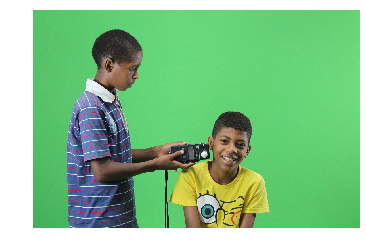

In [23]:
im = cv2.imread("6.bmp")
imshow(im)

### Chá verde

In [38]:
im_hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
(im_hsv[:,:,0] > 40) & (im_hsv[:,:,0] < 75)

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

### Gradiente

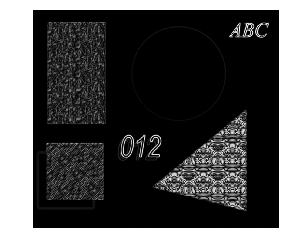

In [9]:
def grad(im_gray,ksize=5):
    #sobel
    sobelx = cv2.Sobel(im_gray,cv2.CV_64F,1,0,ksize=ksize)
    sobely = cv2.Sobel(im_gray,cv2.CV_64F,0,1,ksize=ksize)
    im_grad = np.sqrt(sobelx**2+sobely**2)
    #normaliza
    im_grad = (im_grad-im_grad.min())/(im_grad.max()-im_grad.min())
    return im_grad
im_grad = grad(im_gray,7)
imshow(im_grad)

### Limiarização global

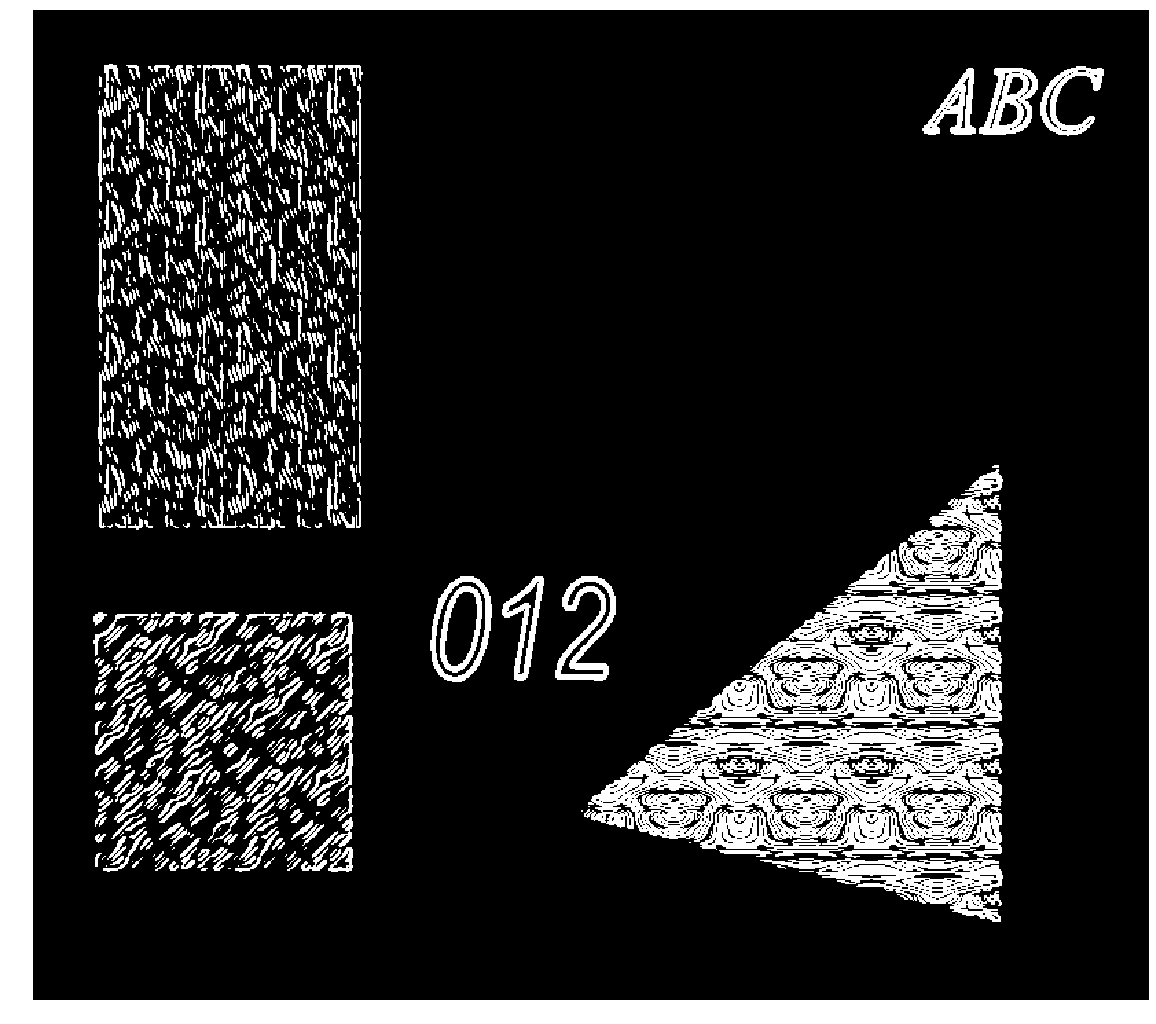

In [10]:
def limiarizacao_global(im, limite = 0.22):
    ret,im_limiarizacao_global = cv2.threshold(im,limite, 1.0, cv2.THRESH_BINARY)
    return f2i(im_limiarizacao_global)
im_bin = limiarizacao_global(im_grad)
imshow(im_bin,True)

### Destroi pequenos objetos 

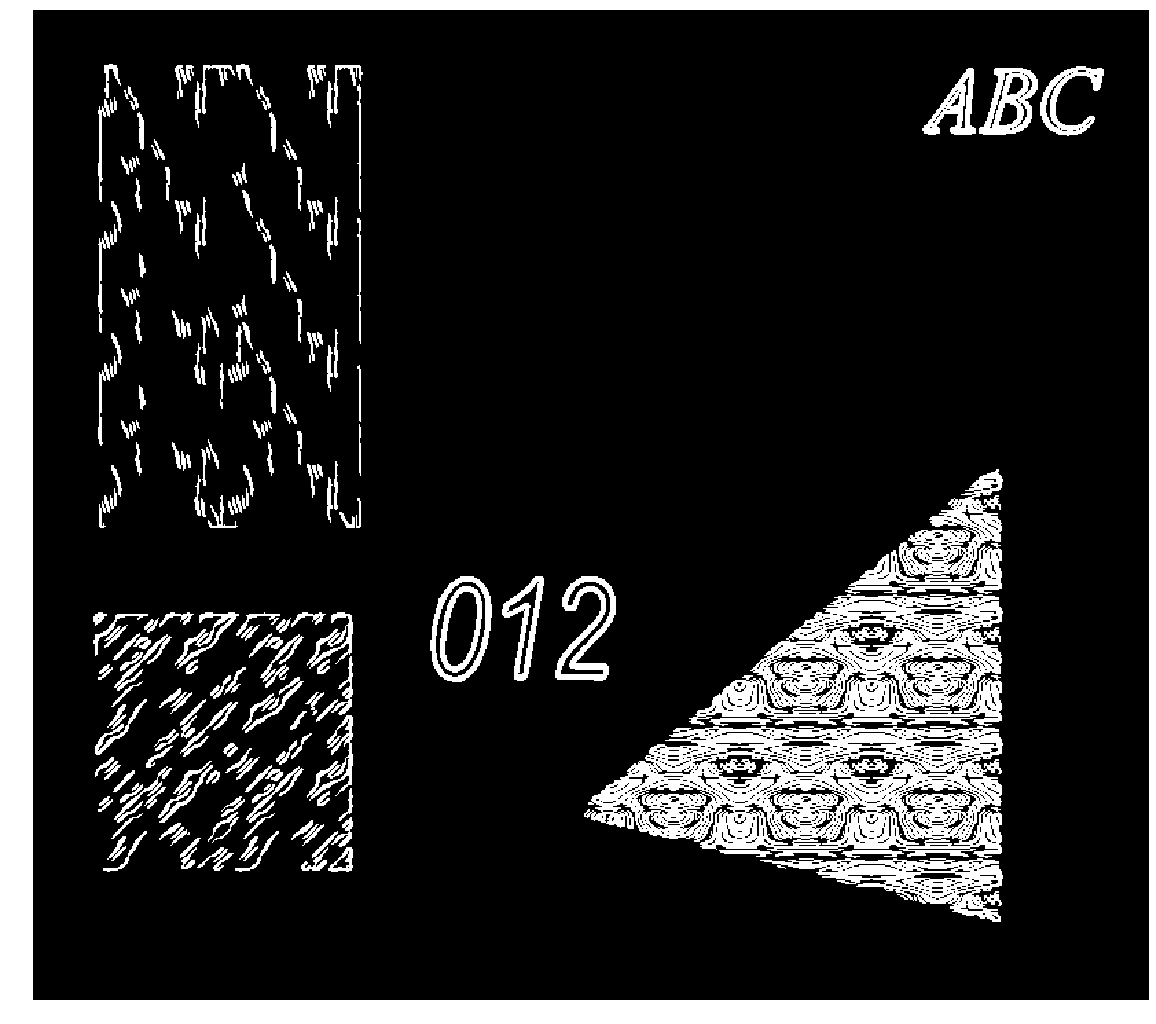

In [11]:
def limpa(im,area_min = 50):
    ret, labels = cv2.connectedComponents(im)
    for i in range(ret):
        mask = labels==i
        if mask.sum()<area_min:
            im[mask] = 0
    return im
im_limp = limpa(im_bin)
imshow(im_limp,True)

### Morphology

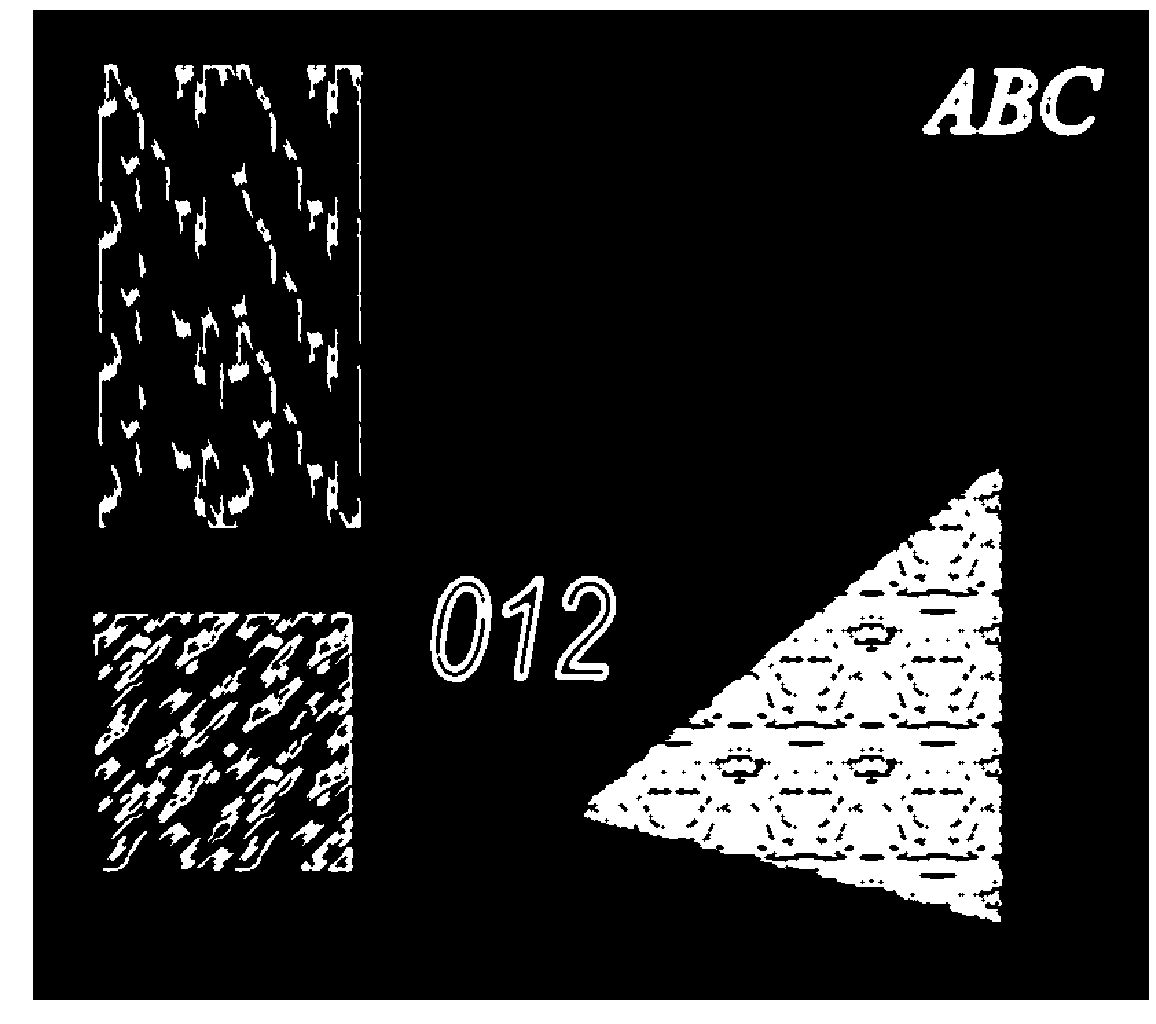

In [12]:
def close(im):
    kernel = np.array([[0,1,0],[1,1,1],[0,1,0]]).astype('uint8')
    #kernel = np.ones((3,3))
    #im_erode = cv2.erode(im_limiarizacao_global,kernel,iterations = 1)
    im_morp = cv2.morphologyEx(im, cv2.MORPH_CLOSE, kernel,iterations=1)
    #im_morp = cv2.morphologyEx(im, cv2.MORPH_OPEN, kernel,iterations=1)
    return im_morp
im_morp = close(im_limp)
imshow(im_morp,True)

### floodFill invertido

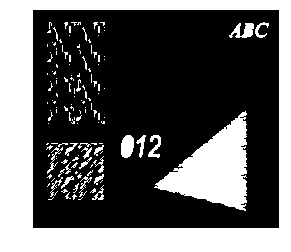

In [13]:
def flood_fill_inv(im):
    im = im.copy()
    h, w = im.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)
    im_flood = cv2.floodFill(im.copy(),mask,(0,0),255)

    im[im_flood[1]<100] = 255
    return im
im_fill = flood_fill_inv(im_morp)
imshow(im_fill)

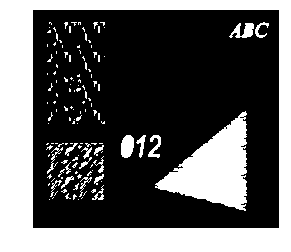

In [14]:
def openn(im):
    kernel = np.array([[0,1,0],[1,1,1],[0,1,0]]).astype('uint8')
    im_morp = cv2.morphologyEx(im, cv2.MORPH_OPEN, kernel,iterations=1)
    return im_morp

im_open = openn(im_fill)
imshow(im_open)

### pinta labels
0 vermelho, 1 amarelo, 2 verde, 3 ciano, 4 azul, 5 rosa, 6 vermelho

In [15]:
def pinta_labels(labels):
    # Map component labels to hue val
    label_hue = np.uint8((30*labels)%180)
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

    # cvt to BGR for display
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2RGB)

    # set bg label to black
    labeled_img[labels==0] = 0
    
    return labeled_img

# 1 Tentativa: Areas

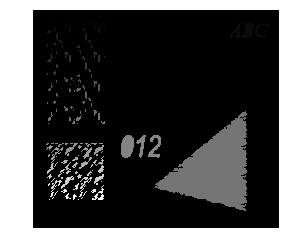

In [16]:
def labels(im):
    ret, labels = cv2.connectedComponents(im.astype('uint8'))
    return labels
im_labels = labels(im_open)
imshow(im_labels)

In [17]:
def areas_blobs(im):
    qnt = im.max()
    #area de cada blob
    areas = np.zeros(qnt).astype(int)
    for i in range(1,qnt+1):
        areas[i-1] = np.sum(im==i)
    
    #areas = areas[areas>20]
    #estima a quantidade de arroz
    return areas

areas = areas_blobs(im_labels)
areas

array([   59,    63,   143,   105,   143,   112,   895,  2322,   157,
         157,    11,    11,    85,    20,    85,    20,   122,     5,
          93,    95,    58,    58,    89,    40,     5,    35,    35,
          77,    45,    32,   100,   100,   188,   157,   157,     8,
          85,    20,     8,     5,    95,    48,    58,    89,    37,
           5,    35,    77,   125,    78,    75,    32,   100,   187,
           5,   157,     5,    11,    85,    20,   144,    85,    15,
          93,    48,    58,    89,    89,    37,    35,   125,    78,
          32,    32,   100,   191,   212, 50633,     5,   157,     5,
           8,    85,    90,   103,    20,     8,  2677,  1047,  1646,
          55,    25,    19,   104,    52,    45,   538,    25,    44,
         107,    52,   491,   168,   107,   161,   357,   147,   393,
          11,     8,     5,    60,    60,    13,    55,   189,    20,
         478,    11,    40,   152,   203,     5,    76,    56,   166,
         140,   324,

In [18]:
from scipy import stats
def moda(areas,i = 25,faz_moda2 = 0):
    #meio que moda, tenta adivinhar o tamanho medio de um arroz
    mode = stats.mode(np.round(areas/i)).mode[0]*i
    print('  moda1:',mode)
    estimativas = areas/mode
    estimativas_round =  np.round(estimativas).astype(int)
    
    return estimativas_round
estimativas = moda(areas)
estimativas,estimativas.sum()

  moda1: 50.0


(array([   1,    1,    3,    2,    3,    2,   18,   46,    3,    3,    0,
           0,    2,    0,    2,    0,    2,    0,    2,    2,    1,    1,
           2,    1,    0,    1,    1,    2,    1,    1,    2,    2,    4,
           3,    3,    0,    2,    0,    0,    0,    2,    1,    1,    2,
           1,    0,    1,    2,    2,    2,    2,    1,    2,    4,    0,
           3,    0,    0,    2,    0,    3,    2,    0,    2,    1,    1,
           2,    2,    1,    1,    2,    2,    1,    1,    2,    4,    4,
        1013,    0,    3,    0,    0,    2,    2,    2,    0,    0,   54,
          21,   33,    1,    0,    0,    2,    1,    1,   11,    0,    1,
           2,    1,   10,    3,    2,    3,    7,    3,    8,    0,    0,
           0,    1,    1,    0,    1,    4,    0,   10,    0,    1,    3,
           4,    0,    2,    1,    3,    3,    6,    1,    6,    4,    2,
           0,    1,    0,    2,    9,    3,    2,   11,    1,    3,    7,
           1,    8,    0,    0,    0, 

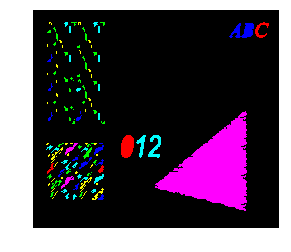

In [19]:
def pinta_qntd(im,estimativas):
    im2 = im.copy()
    i=1
    for e in estimativas:
        im2[im==i] = e 
        i+=1
    return pinta_labels(im2)
im_qtnd = pinta_qntd(im_labels,estimativas)
imshow(im_qtnd)

# Pipelines

In [53]:
def pipeline1(path):
    
    im = cv2.imread(path)
    
    im_gray = cinza(im)
    im_grad = grad(im_gray,9)
    im_bin  = limiarizacao_global(im_grad,0.23)
    im_limp = limpa(im_bin)
    #im_close = close(im_limp)
    im_fill = flood_fill_inv(im_limp)
    im_open = openn(im_fill)
    im_labels = labels(im_open)

    areas = areas_blobs(im_labels)
    estimativas = moda(areas,25)
    im_qtnd = pinta_qntd(im_labels,estimativas)
    
    print('  estimativa',estimativas.sum())
    return im_qtnd

In [54]:
def testa_pipeline(pipeline,paths):
    for path in paths:
        print(path)
        im = pipeline(path)
        #imshow(im,True)
        cv2.imwrite(path+'.png',im[:,:,::-1])

In [56]:
%%time
paths = ["1.jpg", "2.jpg", "3.jpg"]
testa_pipeline(pipeline1,paths)

1.jpg
  moda1: 25.0
  estimativa 283
2.jpg
  moda1: 25.0
  estimativa 6942
3.jpg
  moda1: 950.0
  estimativa 22
CPU times: user 2.61 s, sys: 2.36 ms, total: 2.61 s
Wall time: 2.55 s
